# Проект “With Sense”

Ваш отдел занимается экспериментом по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Например, такое:

A man is crossing a mountain pass on a metal bridge.


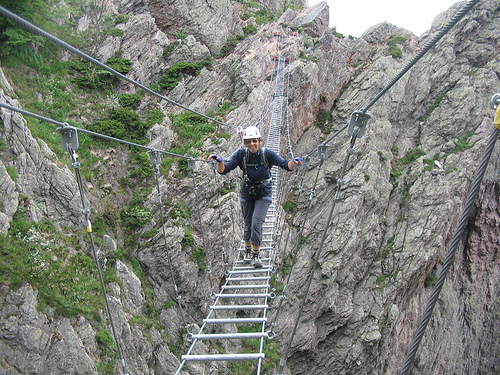

Сервис выводит несколько фотографий с такой же или похожей сценой.


Чтобы эксперимент получил право на жизнь, нужно защитить его перед руководителем компании. Для защиты необходимо презентовать так называемый PoC (Proof of Concept, Проверка концепции) — продемонстрировать, что такой проект практически осуществим. Вам поручено разработать демонстрационную версию поиска изображений по запросу.
Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу. 
На основе лучшей модели можно будет собрать предварительную версию продукта, которую вы покажете руководителю компании.

# Импорты

In [3]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm.notebook import tqdm
import os
import requests
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
from sklearn.metrics import f1_score
import random
from catboost import *
import missingno
from math import *

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from torch.utils.data import (
    Dataset,
    DataLoader
)

from torchvision.io import read_image
from torchvision.models import (
    resnet18, 
    ResNet18_Weights
)

from torchvision.models.feature_extraction import create_feature_extractor

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup
)

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from PIL import Image
from pathlib import Path
import urllib.request
import nltk

from transformers import AutoTokenizer, AutoModel

RANDOM_STATE = 1220
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


PATH_DATA = './Data/to_upload'
PATH_TRAIN_IMAGE_FOLDER = PATH_DATA + '/train_images/'
PATH_TEST_IMAGE_FOLDER = PATH_DATA + '/test_images/'
PATH_TRAIN_DATASET = PATH_DATA + '/train_dataset.csv'
PATH_TEST_QUERIES = PATH_DATA + '/test_queries.csv'
PATH_TEST_IMAGES = PATH_DATA + '/test_images.csv'
PATH_CROWD_ANNOTATIONS = PATH_DATA + '/CrowdAnnotations.tsv'
PATH_EXPERT_ANNOTATIONS = PATH_DATA + '/ExpertAnnotations.tsv'
TEMP='./cache'

In [4]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

Path(TEMP).mkdir(parents=True, exist_ok=True)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SerKer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\SerKer\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SerKer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Загрузка и обзор данных 

In [5]:
try:
    train_df = pd.read_csv(PATH_TRAIN_DATASET)
    test_q = pd.read_csv(PATH_TEST_QUERIES, sep='|', index_col=0)

    CrowdAnnotations_df = pd.read_csv(PATH_CROWD_ANNOTATIONS,
                                    sep='\t', header=None, names=['image', 'query_id', 'pos_share', 'ex_1', 'ex_2'])
    ExpertAnnotations_df = pd.read_csv(PATH_EXPERT_ANNOTATIONS,
                                    sep='\t', header=None, names=['image', 'query_id', 'ex_1', 'ex_2', 'ex_3'])

    test_images_df = pd.read_csv(PATH_TEST_IMAGES, sep='|')
except FileNotFoundError:
    print('Произошла ошибка')

In [6]:
def info_df(df):
    print('------------------------------')
    print('| Информация о наборе данных |')
    print('------------------------------')
    df.info()
    print('-----------------------------------------')
    print('| Первые и последние 5 строчек датасета |')
    print('-----------------------------------------')
    display(df)
    print('--------------------')
    print('| Сумма дубликатов |')
    print('--------------------')
    print(df.duplicated().sum())
    for i in df.select_dtypes(include='object').columns.to_list():
        print('--------------------------------------')
        print(f'| Уникальные значения признака {i} |')
        print('--------------------------------------')
        print(df[i].unique())

In [7]:
for dataset in [train_df, CrowdAnnotations_df, ExpertAnnotations_df, test_q, test_images_df]:
    info_df(dataset)

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
-----------------------------------------
| Первые и последние 5 строчек датасета |
-----------------------------------------


image                     query_id  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1     1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2     2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4     2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
...                         ...                          ...   
5817   757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
5818   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5819   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text  
0     A young child is wearing blue goggles and sitt...  
1     A young child is wearing blue goggles and sitt...  
2     A young child is wearing blue goggles and sitt...  
3     A young child is wearing blue goggles and sitt...  
4     A young child is wearing blue goggles and sitt...  
...                                                 ...  
5817         A man in an ampitheater talking to a boy .  
5818          a old man walks down the uncrowded road .  
5819       A dog stands on the side of a grassy cliff .  
5820                       A blurry photo of two dogs .  
5821                        A man rows his boat below .  

[5822 rows x 3 columns]

--------------------
| Сумма дубликатов |
--------------------
0
--------------------------------------
| Уникальные значения признака image |
--------------------------------------
['1056338697_4f7d7ce270.jpg' '1262583859_653f1469a9.jpg'
 '2447284966_d6bbdb4b6e.jpg' '2549968784_39bfbe44f9.jpg'
 '2621415349_ef1a7e73be.jpg' '3030566410_393c36a6c5.jpg'
 '3155451946_c0862c70cb.jpg' '3222041930_f642f49d28.jpg'
 '343218198_1ca90e0734.jpg' '3718964174_cb2dc1615e.jpg'
 '3741827382_71e93298d0.jpg' '486712504_36be449055.jpg'
 '1167669558_87a8a467d6.jpg' '2616643090_4f2d2d1a44.jpg'
 '2648165716_02e2e74fd6.jpg' '2718495608_d8533e3ac5.jpg'
 '3244747165_17028936e0.jpg' '3503689049_63212220be.jpg'
 '3506560025_8d0f4f9ac4.jpg' '700884207_d3ec546494.jpg'
 '3187395715_f2940c2b72.jpg' '463978865_c87c6ca84c.jpg'
 '488590040_35a3e96c89.jpg' '534875358_6ea30d3091.jpg'
 '3208074567_ac44aeb3f3.jpg' '3251976937_20625dc2b8.jpg'
 '370713359_7560808550.jpg' '1962729184_6996e128e7.jpg'
 '2101457132_69c950bc45.jpg

image                     query_id  pos_share  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   1.000000   
1      1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   0.000000   
2      1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   0.000000   
3      1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.000000   
4      1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   0.000000   
...                          ...                          ...        ...   
47825   997722733_0cb5439472.jpg   543007912_23fc735b99.jpg#2   0.000000   
47826   997722733_0cb5439472.jpg   544576742_283b65fa0d.jpg#2   0.333333   
47827   997722733_0cb5439472.jpg   872622575_ba1d3632cc.jpg#2   1.000000   
47828   997722733_0cb5439472.jpg   888425986_e4b6c12324.jpg#2   0.000000   
47829   997722733_0cb5439472.jpg   997722733_0cb5439472.jpg#2   0.666667   

       ex_1  ex_2  
0         3     0  
1         0     3  
2         0     3  
3         0     3  
4         0     3  
...     ...   ...  
47825     0     3  
47826     1     2  
47827     3     0  
47828     0     3  
47829     2     1  

[47830 rows x 5 columns]

--------------------
| Сумма дубликатов |
--------------------
0
--------------------------------------
| Уникальные значения признака image |
--------------------------------------
['1056338697_4f7d7ce270.jpg' '106490881_5a2dd9b7bd.jpg'
 '1082379191_ec1e53f996.jpg' '1084040636_97d9633581.jpg'
 '1096395242_fc69f0ae5a.jpg' '1107246521_d16a476380.jpg'
 '1119015538_e8e796281e.jpg' '1122944218_8eb3607403.jpg'
 '1131800850_89c7ffd477.jpg' '1131932671_c8d17751b3.jpg'
 '113678030_87a6a6e42e.jpg' '114051287_dd85625a04.jpg'
 '115684808_cb01227802.jpg' '1167669558_87a8a467d6.jpg'
 '1174525839_7c1e6cfa86.jpg' '1174629344_a2e1a2bdbf.jpg'
 '1220401002_3f44b1f3f7.jpg' '1224851143_33bcdd299c.jpg'
 '1237985362_dbafc59280.jpg' '1248940539_46d33ed487.jpg'
 '1258913059_07c613f7ff.jpg' '1262583859_653f1469a9.jpg'
 '1267711451_e2a754b4f8.jpg' '127488876_f2d2a89588.jpg'
 '127490019_7c5c08cb11.jpg' '1282392036_5a0328eb86.jpg'
 '1287073593_f3d2a62455.jpg' '1287475186_2dee85f1a5.jpg'
 '1298295313_db1f4c6522.jp

image                     query_id  ex_1  ex_2  ex_3
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1     1
1     1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     1     1     2
2     1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     1     1     2
3     1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2     1     2     2
4     1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2     1     1     2
...                         ...                          ...   ...   ...   ...
5817   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2     1     1     1
5818   997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2     1     1     1
5819   997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2     1     1     2
5820   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2     1     1     1
5821   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2     3     3     3

[5822 rows x 5 columns]

--------------------
| Сумма дубликатов |
--------------------
0
--------------------------------------
| Уникальные значения признака image |
--------------------------------------
['1056338697_4f7d7ce270.jpg' '106490881_5a2dd9b7bd.jpg'
 '1082379191_ec1e53f996.jpg' '1084040636_97d9633581.jpg'
 '1096395242_fc69f0ae5a.jpg' '1107246521_d16a476380.jpg'
 '1119015538_e8e796281e.jpg' '1122944218_8eb3607403.jpg'
 '1131800850_89c7ffd477.jpg' '1131932671_c8d17751b3.jpg'
 '113678030_87a6a6e42e.jpg' '114051287_dd85625a04.jpg'
 '115684808_cb01227802.jpg' '1167669558_87a8a467d6.jpg'
 '1174525839_7c1e6cfa86.jpg' '1174629344_a2e1a2bdbf.jpg'
 '1220401002_3f44b1f3f7.jpg' '1224851143_33bcdd299c.jpg'
 '1237985362_dbafc59280.jpg' '1248940539_46d33ed487.jpg'
 '1258913059_07c613f7ff.jpg' '1262583859_653f1469a9.jpg'
 '1267711451_e2a754b4f8.jpg' '127488876_f2d2a89588.jpg'
 '127490019_7c5c08cb11.jpg' '1282392036_5a0328eb86.jpg'
 '1287073593_f3d2a62455.jpg' '1287475186_2dee85f1a5.jpg'
 '1298295313_db1f4c6522.jp

query_id  \
0    1177994172_10d143cb8d.jpg#0   
1    1177994172_10d143cb8d.jpg#1   
2    1177994172_10d143cb8d.jpg#2   
3    1177994172_10d143cb8d.jpg#3   
4    1177994172_10d143cb8d.jpg#4   
..                           ...   
495   989851184_9ef368e520.jpg#0   
496   989851184_9ef368e520.jpg#1   
497   989851184_9ef368e520.jpg#2   
498   989851184_9ef368e520.jpg#3   
499   989851184_9ef368e520.jpg#4   

                                            query_text  \
0    Two blonde boys , one in a camouflage shirt an...   
1    Two boys are squirting water guns at each other .   
2              Two boys spraying each other with water   
3    Two children wearing jeans squirt water at eac...   
4    Two young boys are squirting water at each oth...   
..                                                 ...   
495          A black dog has a dumbbell in his mouth .   
496  A black dog has a dumbbell in his mouth lookin...   
497  A black dog holding a weight in its mouth stan...   
498  A black dog holds a small white dumbbell in it...   
499  The black dog has a toy in its mouth and a per...   

                         image  
0    1177994172_10d143cb8d.jpg  
1    1177994172_10d143cb8d.jpg  
2    1177994172_10d143cb8d.jpg  
3    1177994172_10d143cb8d.jpg  
4    1177994172_10d143cb8d.jpg  
..                         ...  
495   989851184_9ef368e520.jpg  
496   989851184_9ef368e520.jpg  
497   989851184_9ef368e520.jpg  
498   989851184_9ef368e520.jpg  
499   989851184_9ef368e520.jpg  

[500 rows x 3 columns]

--------------------
| Сумма дубликатов |
--------------------
0
--------------------------------------
| Уникальные значения признака query_id |
--------------------------------------
['1177994172_10d143cb8d.jpg#0' '1177994172_10d143cb8d.jpg#1'
 '1177994172_10d143cb8d.jpg#2' '1177994172_10d143cb8d.jpg#3'
 '1177994172_10d143cb8d.jpg#4' '1232148178_4f45cc3284.jpg#0'
 '1232148178_4f45cc3284.jpg#1' '1232148178_4f45cc3284.jpg#2'
 '1232148178_4f45cc3284.jpg#3' '1232148178_4f45cc3284.jpg#4'
 '123997871_6a9ca987b1.jpg#0' '123997871_6a9ca987b1.jpg#1'
 '123997871_6a9ca987b1.jpg#2' '123997871_6a9ca987b1.jpg#3'
 '123997871_6a9ca987b1.jpg#4' '1319634306_816f21677f.jpg#0'
 '1319634306_816f21677f.jpg#1' '1319634306_816f21677f.jpg#2'
 '1319634306_816f21677f.jpg#3' '1319634306_816f21677f.jpg#4'
 '1429546659_44cb09cbe2.jpg#0' '1429546659_44cb09cbe2.jpg#1'
 '1429546659_44cb09cbe2.jpg#2' '1429546659_44cb09cbe2.jpg#3'
 '1429546659_44cb09cbe2.jpg#4' '1468389504_c724bdcad0.jpg#0'
 '1468389504_c724bdcad0.jpg

image
0   3356748019_2251399314.jpg
1   2887171449_f54a2b9f39.jpg
2   3089107423_81a24eaf18.jpg
3   1429546659_44cb09cbe2.jpg
4   1177994172_10d143cb8d.jpg
..                        ...
95  2431120202_b24fe2333a.jpg
96  2399219552_bbba0a9a59.jpg
97  3091962081_194f2f3bd4.jpg
98  2670637584_d96efb8afa.jpg
99  2346402952_e47d0065b6.jpg

[100 rows x 1 columns]

--------------------
| Сумма дубликатов |
--------------------
0
--------------------------------------
| Уникальные значения признака image |
--------------------------------------
['3356748019_2251399314.jpg' '2887171449_f54a2b9f39.jpg'
 '3089107423_81a24eaf18.jpg' '1429546659_44cb09cbe2.jpg'
 '1177994172_10d143cb8d.jpg' '424307754_1e2f44d265.jpg'
 '3044359043_627488ddf0.jpg' '3396275223_ee080df8b5.jpg'
 '2977379863_2e8d7a104e.jpg' '634891010_9fa189effb.jpg'
 '3555573680_41c1540a86.jpg' '2060031241_a3ae7a06bb.jpg'
 '2885891981_6b02620ae9.jpg' '3438981089_2ef1a6353c.jpg'
 '661749711_6f408dad62.jpg' '1468389504_c724bdcad0.jpg'
 '989851184_9ef368e520.jpg' '2505465055_f1e6cf9b76.jpg'
 '123997871_6a9ca987b1.jpg' '3653484549_f316590b0f.jpg'
 '3488087117_2719647989.jpg' '3330333217_1a69497a74.jpg'
 '862156271_3eacea90a8.jpg' '2428094795_d3a8f46046.jpg'
 '3421547427_53411b6278.jpg' '3722572342_6904d11d52.jpg'
 '989754491_7e53fb4586.jpg' '3287969199_08e775d896.jpg'
 '2201192417_d934730fea.jpg

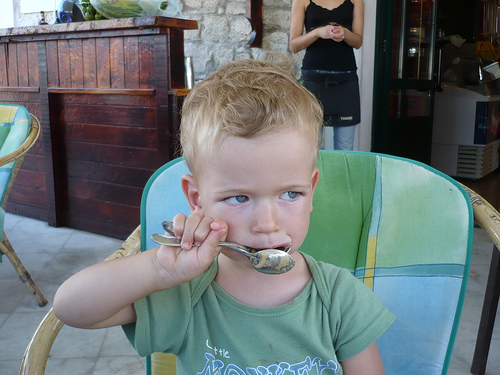

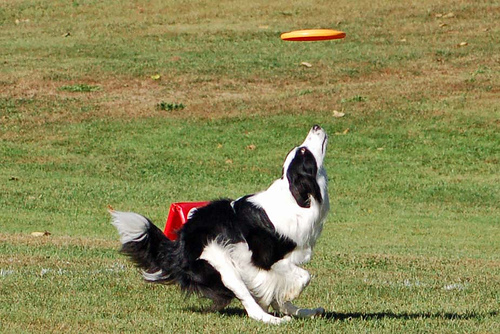

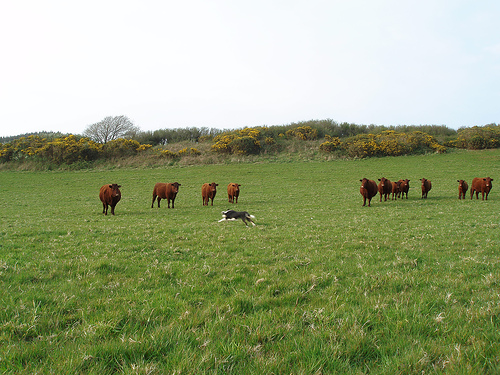

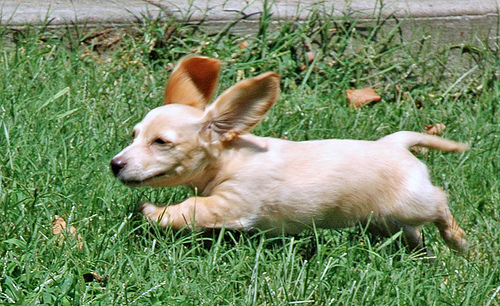

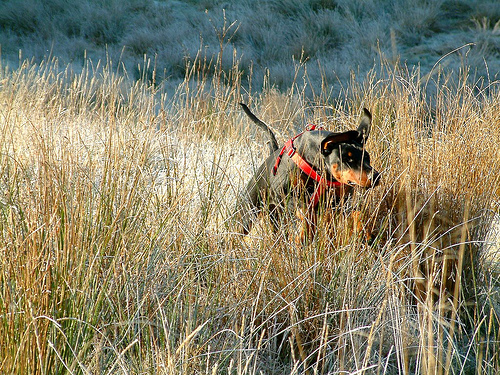

In [8]:
for i in range(280, 285):
    image_name = train_df.iloc[i]['image']
    img = Image.open(PATH_TRAIN_IMAGE_FOLDER+image_name).convert('RGB') 
    display(img)

**Вывод**

Данные о фотографиях и их описании загружены! Можно отметить тот факт, что все фотографии в тренировачных датасетах имеют отношение к второй группе в базе данных, которая обозначается (#2), тогда как в тестовом наборе данные есть вариация этих групп, потенциально это может сыграть на качестве прогноза обученной модели.

**Описание данных**

**train_dataset**

* `image` - изображение в формате `jpg`
* `query_id` - идентификатор описания
* `query_text` - описание

**CrowdAnnotations**

* `image` - Имя файла изображения;
* `query_id` - Идентификатор описания;
* `positive` - Доля людей, подтвердивших, что описание соответствует изображению;
* `ex_1` - Количество человек, подтвердивших, что описание соответствует изображению;
* `ex_2` - Количество человек, подтвердивших, что описание не соответствует изображению.

**ExpertAnnotations**

Описание колонок:
* `image` - Имя файла изображения;
* `query_id` - Идентификатор описания;
* `ex_1` — оценка 1 эксперта;
* `ex_2` — оценка 2 эксперта;
* `ex_3` — оценка 3 эксперта.

****************************************************************

Выполним обработку данных краудсорсинга:
* добавим колонку `pos_share` с долей, подтвердивших, что описание соотвествует изображению.

Эксперты ставят оценки по шкале от `1` до `4`, где
* `1` — изображение и запрос совершенно не соответствуют друг другу;
* `2` — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует;
* `3` — запрос и текст соответствуют с точностью до некоторых деталей;
* `4` — запрос и текст соответствуют полностью.

___Примечание___: "положительными" будем считать оценки `3` и `4`

In [9]:
def calc_avg_exp(row):
    array = [row['ex_1'], row['ex_2'], row['ex_3']]
    u, c = np.unique(array, return_counts=True)

    y = u[c == c.max()]

    percentages = dict(zip(u, c / len(array)))

    row['ex_0'] = y[0] if len(y) == 1 else 0
    row['pos_share'] = percentages[y[0]] if len(y) == 1 and y[0] in [3, 4] else 0

    return row

def calc_avg_crd(row):
    array = [row['ex_1'], row['ex_2']]
    u, c = np.unique(array, return_counts=True)

    y = u[c == c.max()]

    percentages = dict(zip(u, c / len(array)))

    row['pos_share'] = percentages[y[0]] if len(y) == 1 and y[0] in [3, 4] else 0

    return row

In [10]:
ExpertAnnotations_df = ExpertAnnotations_df.apply(calc_avg_exp, axis=1)

In [11]:
ExpertAnnotations_df

image                     query_id  ex_1  ex_2  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1   
1     1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     1     1   
2     1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     1     1   
3     1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2     1     2   
4     1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2     1     1   
...                         ...                          ...   ...   ...   
5817   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2     1     1   
5818   997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2     1     1   
5819   997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2     1     1   
5820   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2     1     1   
5821   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2     3     3   

      ex_3  ex_0  pos_share  
0        1     1        0.0  
1        2     1        0.0  
2        2     1        0.0  
3        2     2        0.0  
4        2     1        0.0  
...    ...   ...        ...  
5817     1     1        0.0  
5818     1     1        0.0  
5819     2     1        0.0  
5820     1     1        0.0  
5821     3     3        1.0  

[5822 rows x 7 columns]

Уберем те мнения экспертов и краудсорсинга, где они полностью разошлись

In [12]:
ExpertAnnotations_df_ex_0 = ExpertAnnotations_df[ExpertAnnotations_df['ex_0'] == 0]

display(ExpertAnnotations_df_ex_0.head())

ExpertAnnotations_df.drop(ExpertAnnotations_df_ex_0.index, inplace=True)

image                     query_id  ex_1  ex_2  ex_3  \
17   1082379191_ec1e53f996.jpg  1536774449_e16b1b6382.jpg#2     1     2     3   
40   1119015538_e8e796281e.jpg  2534502836_7a75305655.jpg#2     2     3     4   
47   1122944218_8eb3607403.jpg  3325497914_f9014d615b.jpg#2     2     3     4   
168  1287475186_2dee85f1a5.jpg  2918769188_565dd48060.jpg#2     1     2     3   
199  1329832826_432538d331.jpg  1536774449_e16b1b6382.jpg#2     1     2     3   

     ex_0  pos_share  
17      0        0.0  
40      0        0.0  
47      0        0.0  
168     0        0.0  
199     0        0.0

In [13]:
CrowdAnnotations_df = CrowdAnnotations_df.apply(calc_avg_crd, axis=1)

In [14]:
CrowdAnnotations_df.set_index(['image', 'query_id'], inplace=True)
ExpertAnnotations_df.set_index(['image', 'query_id'], inplace=True)

In [15]:
annotations = CrowdAnnotations_df.merge(
    ExpertAnnotations_df,
    how='outer',
    left_index=True,
    right_index=True,
    suffixes=('_crowd', '_expert')
)

In [16]:
annotations

pos_share_crowd  \
image                     query_id                                       
1056338697_4f7d7ce270.jpg 1056338697_4f7d7ce270.jpg#2              0.0   
                          114051287_dd85625a04.jpg#2               0.0   
                          1427391496_ea512cbe7f.jpg#2              0.0   
                          2073964624_52da3a0fc4.jpg#2              0.0   
                          2083434441_a93bc6306b.jpg#2              0.0   
...                                                                ...   
997722733_0cb5439472.jpg  543007912_23fc735b99.jpg#2               0.0   
                          544576742_283b65fa0d.jpg#2               0.0   
                          872622575_ba1d3632cc.jpg#2               0.0   
                          888425986_e4b6c12324.jpg#2               0.0   
                          997722733_0cb5439472.jpg#2               0.0   

                                                       ex_1_crowd  ex_2_crowd  \
image                     query_id                                              
1056338697_4f7d7ce270.jpg 1056338697_4f7d7ce270.jpg#2         3.0         0.0   
                          114051287_dd85625a04.jpg#2          0.0         3.0   
                          1427391496_ea512cbe7f.jpg#2         0.0         3.0   
                          2073964624_52da3a0fc4.jpg#2         0.0         3.0   
                          2083434441_a93bc6306b.jpg#2         0.0         3.0   
...                                                           ...         ...   
997722733_0cb5439472.jpg  543007912_23fc735b99.jpg#2          0.0         3.0   
                          544576742_283b65fa0d.jpg#2          1.0         2.0   
                          872622575_ba1d3632cc.jpg#2          3.0         0.0   
                          888425986_e4b6c12324.jpg#2          0.0         3.0   
                          997722733_0cb5439472.jpg#2          2.0         1.0   

                                                       ex_1_expert  \
image                     query_id                                   
1056338697_4f7d7ce270.jpg 1056338697_4f7d7ce270.jpg#2          NaN   
                          114051287_dd85625a04.jpg#2           NaN   
                          1427391496_ea512cbe7f.jpg#2          NaN   
                          2073964624_52da3a0fc4.jpg#2          NaN   
                          2083434441_a93bc6306b.jpg#2          NaN   
...                                                            ...   
997722733_0cb5439472.jpg  543007912_23fc735b99.jpg#2           NaN   
                          544576742_283b65fa0d.jpg#2           NaN   
                          872622575_ba1d3632cc.jpg#2           NaN   
                          888425986_e4b6c12324.jpg#2           NaN   
                          997722733_0cb5439472.jpg#2           NaN   

                                                       ex_2_expert  ex_3  \
image                     query_id                                         
1056338697_4f7d7ce270.jpg 1056338697_4f7d7ce270.jpg#2          NaN   NaN   
                          114051287_dd85625a04.jpg#2           NaN   NaN   
                          1427391496_ea512cbe7f.jpg#2          NaN   NaN   
                          2073964624_52da3a0fc4.jpg#2          NaN   NaN   
                          2083434441_a93bc6306b.jpg#2          NaN   NaN   
...                                                            ...   ...   
997722733_0cb5439472.jpg  543007912_23fc735b99.jpg#2           NaN   NaN   
                          544576742_283b65fa0d.jpg#2           NaN   NaN   
                          872622575_ba1d3632cc.jpg#2           NaN   NaN   
                          888425986_e4b6c12324.jpg#2           NaN   NaN   
                          997722733_0cb5439472.jpg#2           NaN   NaN   

                                                       ex_0  pos_share_expert  
image                     query_id                        

Объединение оценок

В исходных данных имеется большое количество оценок от краудсорсинга, но на большинство их оценок, нет оценок экспертов, чтобы не терять данные попробуем решить задачу регрессии и обучим модель для решение регрессионной задачи по восстановлению потенциальной оценки экспертов, на основе данных где есть оценка краудсорсинга и экспертов. В качестве модели возьмем CatBoost

In [17]:
train_reg_df = annotations.loc[(annotations['pos_share_crowd'].isna() == False) & (annotations['pos_share_expert'].isna() == False)]

In [18]:
train_reg_df = train_reg_df.reset_index()

In [19]:
train_reg_df

image                     query_id  pos_share_crowd  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2              0.0   
1     1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2              0.0   
2     1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2              0.0   
3     1084040636_97d9633581.jpg   256085101_2c2617c5d0.jpg#2              0.0   
4     1084040636_97d9633581.jpg  3396157719_6807d52a81.jpg#2              0.0   
...                         ...                          ...              ...   
2253   979383193_0a542a059d.jpg  3244747165_17028936e0.jpg#2              0.0   
2254   979383193_0a542a059d.jpg  3482062809_3b694322c4.jpg#2              0.0   
2255   997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2              0.0   
2256   997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2              0.0   
2257   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2              0.0   

      ex_1_crowd  ex_2_crowd  ex_1_expert  ex_2_expert  ex_3  ex_0  \
0            0.0         3.0          1.0          1.0   1.0   1.0   
1            0.0         3.0          1.0          1.0   2.0   1.0   
2            0.0         3.0          1.0          1.0   2.0   1.0   
3            1.0         2.0          2.0          3.0   3.0   3.0   
4            0.0         3.0          1.0          2.0   2.0   2.0   
...          ...         ...          ...          ...   ...   ...   
2253         0.0         3.0          2.0          2.0   2.0   2.0   
2254         0.0         3.0          1.0          2.0   2.0   2.0   
2255         0.0         3.0          1.0          1.0   1.0   1.0   
2256         0.0         3.0          1.0          1.0   2.0   1.0   
2257         1.0         2.0          3.0          3.0   3.0   3.0   

      pos_share_expert  
0             0.000000  
1             0.000000  
2             0.000000  
3             0.666667  
4             0.000000  
...                ...  
2253          0.000000  
2254          0.000000  
2255          0.000000  
2256          0.000000  
2257          1.000000  

[2258 rows x 10 columns]

In [20]:
train_reg_df['avg_score'] = (train_reg_df['pos_share_expert'] + train_reg_df['pos_share_crowd']) / 2.

In [21]:
train_reg_df

image                     query_id  pos_share_crowd  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2              0.0   
1     1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2              0.0   
2     1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2              0.0   
3     1084040636_97d9633581.jpg   256085101_2c2617c5d0.jpg#2              0.0   
4     1084040636_97d9633581.jpg  3396157719_6807d52a81.jpg#2              0.0   
...                         ...                          ...              ...   
2253   979383193_0a542a059d.jpg  3244747165_17028936e0.jpg#2              0.0   
2254   979383193_0a542a059d.jpg  3482062809_3b694322c4.jpg#2              0.0   
2255   997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2              0.0   
2256   997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2              0.0   
2257   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2              0.0   

      ex_1_crowd  ex_2_crowd  ex_1_expert  ex_2_expert  ex_3  ex_0  \
0            0.0         3.0          1.0          1.0   1.0   1.0   
1            0.0         3.0          1.0          1.0   2.0   1.0   
2            0.0         3.0          1.0          1.0   2.0   1.0   
3            1.0         2.0          2.0          3.0   3.0   3.0   
4            0.0         3.0          1.0          2.0   2.0   2.0   
...          ...         ...          ...          ...   ...   ...   
2253         0.0         3.0          2.0          2.0   2.0   2.0   
2254         0.0         3.0          1.0          2.0   2.0   2.0   
2255         0.0         3.0          1.0          1.0   1.0   1.0   
2256         0.0         3.0          1.0          1.0   2.0   1.0   
2257         1.0         2.0          3.0          3.0   3.0   3.0   

      pos_share_expert  avg_score  
0             0.000000   0.000000  
1             0.000000   0.000000  
2             0.000000   0.000000  
3             0.666667   0.333333  
4             0.000000   0.000000  
...                ...        ...  
2253          0.000000   0.000000  
2254          0.000000   0.000000  
2255          0.000000   0.000000  
2256          0.000000   0.000000  
2257          1.000000   0.500000  

[2258 rows x 11 columns]

In [22]:
target = train_reg_df['avg_score']
features = train_reg_df.drop(['image', 'query_id', 'avg_score', 'ex_1_expert', 'ex_2_expert', 'ex_3', 'ex_0','pos_share_expert'], axis=1)

In [23]:
features

pos_share_crowd  ex_1_crowd  ex_2_crowd
0                 0.0         0.0         3.0
1                 0.0         0.0         3.0
2                 0.0         0.0         3.0
3                 0.0         1.0         2.0
4                 0.0         0.0         3.0
...               ...         ...         ...
2253              0.0         0.0         3.0
2254              0.0         0.0         3.0
2255              0.0         0.0         3.0
2256              0.0         0.0         3.0
2257              0.0         1.0         2.0

[2258 rows x 3 columns]

In [24]:
features_test = annotations.loc[(annotations['pos_share_crowd'].isna() == False) & (annotations['pos_share_expert'].isna() == True)]

In [25]:
features_test = features_test.reset_index()

In [26]:
features_test = features_test.drop(['image', 'query_id', 'ex_1_expert', 'ex_2_expert', 'ex_3', 'ex_0','pos_share_expert'], axis=1)

In [27]:
features_test

pos_share_crowd  ex_1_crowd  ex_2_crowd
0                  0.0         3.0         0.0
1                  0.0         0.0         3.0
2                  0.0         0.0         3.0
3                  0.0         0.0         3.0
4                  0.0         0.0         3.0
...                ...         ...         ...
45567              0.0         0.0         3.0
45568              0.0         1.0         2.0
45569              0.0         3.0         0.0
45570              0.0         0.0         3.0
45571              0.0         2.0         1.0

[45572 rows x 3 columns]

In [28]:
cat_features = features.select_dtypes(include='object').columns.to_list()

In [29]:
cat_model = CatBoostRegressor(loss_function='RMSE',
                                      depth=10,
                                      learning_rate=0.1,
                                      random_state=RANDOM_STATE,
                                      task_type="GPU",
                                      cat_features=cat_features,
                                      ).fit(features, target,
                                            plot=False, verbose=True)

0:	learn: 0.1981376	total: 29.4ms	remaining: 29.4s
1:	learn: 0.1885058	total: 37ms	remaining: 18.5s
2:	learn: 0.1803992	total: 44.5ms	remaining: 14.8s
3:	learn: 0.1735675	total: 49.7ms	remaining: 12.4s
4:	learn: 0.1676915	total: 54.8ms	remaining: 10.9s
5:	learn: 0.1628193	total: 60.6ms	remaining: 10s
6:	learn: 0.1587581	total: 66.4ms	remaining: 9.42s
7:	learn: 0.1553924	total: 73ms	remaining: 9.05s
8:	learn: 0.1525277	total: 79.5ms	remaining: 8.75s
9:	learn: 0.1501954	total: 84.4ms	remaining: 8.36s
10:	learn: 0.1482773	total: 90.8ms	remaining: 8.17s
11:	learn: 0.1467069	total: 96.2ms	remaining: 7.92s
12:	learn: 0.1453364	total: 103ms	remaining: 7.82s
13:	learn: 0.1442413	total: 109ms	remaining: 7.66s
14:	learn: 0.1433569	total: 115ms	remaining: 7.53s
15:	learn: 0.1427008	total: 120ms	remaining: 7.4s
16:	learn: 0.1421455	total: 126ms	remaining: 7.3s
17:	learn: 0.1416935	total: 147ms	remaining: 8.01s
18:	learn: 0.1413002	total: 152ms	remaining: 7.85s
19:	learn: 0.1409133	total: 158ms	rem

In [30]:
predicted = cat_model.predict(features_test)

In [31]:
annotations

pos_share_crowd  \
image                     query_id                                       
1056338697_4f7d7ce270.jpg 1056338697_4f7d7ce270.jpg#2              0.0   
                          114051287_dd85625a04.jpg#2               0.0   
                          1427391496_ea512cbe7f.jpg#2              0.0   
                          2073964624_52da3a0fc4.jpg#2              0.0   
                          2083434441_a93bc6306b.jpg#2              0.0   
...                                                                ...   
997722733_0cb5439472.jpg  543007912_23fc735b99.jpg#2               0.0   
                          544576742_283b65fa0d.jpg#2               0.0   
                          872622575_ba1d3632cc.jpg#2               0.0   
                          888425986_e4b6c12324.jpg#2               0.0   
                          997722733_0cb5439472.jpg#2               0.0   

                                                       ex_1_crowd  ex_2_crowd  \
image                     query_id                                              
1056338697_4f7d7ce270.jpg 1056338697_4f7d7ce270.jpg#2         3.0         0.0   
                          114051287_dd85625a04.jpg#2          0.0         3.0   
                          1427391496_ea512cbe7f.jpg#2         0.0         3.0   
                          2073964624_52da3a0fc4.jpg#2         0.0         3.0   
                          2083434441_a93bc6306b.jpg#2         0.0         3.0   
...                                                           ...         ...   
997722733_0cb5439472.jpg  543007912_23fc735b99.jpg#2          0.0         3.0   
                          544576742_283b65fa0d.jpg#2          1.0         2.0   
                          872622575_ba1d3632cc.jpg#2          3.0         0.0   
                          888425986_e4b6c12324.jpg#2          0.0         3.0   
                          997722733_0cb5439472.jpg#2          2.0         1.0   

                                                       ex_1_expert  \
image                     query_id                                   
1056338697_4f7d7ce270.jpg 1056338697_4f7d7ce270.jpg#2          NaN   
                          114051287_dd85625a04.jpg#2           NaN   
                          1427391496_ea512cbe7f.jpg#2          NaN   
                          2073964624_52da3a0fc4.jpg#2          NaN   
                          2083434441_a93bc6306b.jpg#2          NaN   
...                                                            ...   
997722733_0cb5439472.jpg  543007912_23fc735b99.jpg#2           NaN   
                          544576742_283b65fa0d.jpg#2           NaN   
                          872622575_ba1d3632cc.jpg#2           NaN   
                          888425986_e4b6c12324.jpg#2           NaN   
                          997722733_0cb5439472.jpg#2           NaN   

                                                       ex_2_expert  ex_3  \
image                     query_id                                         
1056338697_4f7d7ce270.jpg 1056338697_4f7d7ce270.jpg#2          NaN   NaN   
                          114051287_dd85625a04.jpg#2           NaN   NaN   
                          1427391496_ea512cbe7f.jpg#2          NaN   NaN   
                          2073964624_52da3a0fc4.jpg#2          NaN   NaN   
                          2083434441_a93bc6306b.jpg#2          NaN   NaN   
...                                                            ...   ...   
997722733_0cb5439472.jpg  543007912_23fc735b99.jpg#2           NaN   NaN   
                          544576742_283b65fa0d.jpg#2           NaN   NaN   
                          872622575_ba1d3632cc.jpg#2           NaN   NaN   
                          888425986_e4b6c12324.jpg#2           NaN   NaN   
                          997722733_0cb5439472.jpg#2           NaN   NaN   

                                                       ex_0  pos_share_expert  
image                     query_id                        

In [32]:
full_dataset = annotations.copy()

In [33]:
full_dataset.loc[(full_dataset['pos_share_crowd'].isna() == False) & (full_dataset['pos_share_expert'].isna() == False), 'avg_score'] = [i for i in train_reg_df['avg_score']]

In [34]:
full_dataset.loc[(full_dataset['pos_share_crowd'].isna() == False) & (full_dataset['pos_share_expert'].isna() == True), 'avg_score'] = [i for i in predicted]

In [35]:
full_dataset = full_dataset.drop(['pos_share_crowd','ex_1_crowd','ex_2_crowd',	'ex_1_expert',	'ex_2_expert',	'ex_3',	'ex_0',	'pos_share_expert'], axis=1)

In [36]:
full_dataset = full_dataset.reset_index()

In [37]:
train_df

image                     query_id  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1     1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2     2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4     2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
...                         ...                          ...   
5817   757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
5818   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5819   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text  
0     A young child is wearing blue goggles and sitt...  
1     A young child is wearing blue goggles and sitt...  
2     A young child is wearing blue goggles and sitt...  
3     A young child is wearing blue goggles and sitt...  
4     A young child is wearing blue goggles and sitt...  
...                                                 ...  
5817         A man in an ampitheater talking to a boy .  
5818          a old man walks down the uncrowded road .  
5819       A dog stands on the side of a grassy cliff .  
5820                       A blurry photo of two dogs .  
5821                        A man rows his boat below .  

[5822 rows x 3 columns]

In [38]:
full_dataset

image                     query_id  avg_score
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   0.463502
1      1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   0.045580
2      1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   0.045580
3      1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.045580
4      1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   0.045580
...                          ...                          ...        ...
51263   997722733_0cb5439472.jpg   543007912_23fc735b99.jpg#2   0.045580
51264   997722733_0cb5439472.jpg   544576742_283b65fa0d.jpg#2   0.270646
51265   997722733_0cb5439472.jpg   872622575_ba1d3632cc.jpg#2   0.463502
51266   997722733_0cb5439472.jpg   888425986_e4b6c12324.jpg#2   0.045580
51267   997722733_0cb5439472.jpg   997722733_0cb5439472.jpg#2   0.380293

[51268 rows x 3 columns]

In [39]:
full = full_dataset.merge(train_df, on='query_id')

In [40]:
print('--------------------------------')
print('| Proportion of missing values |')
print('--------------------------------')
(pd.DataFrame(round(full
.isna().mean()*100,1)).style.background_gradient('coolwarm'))

--------------------------------
| Proportion of missing values |
--------------------------------


In [41]:
full

image_x                     query_id  avg_score  \
0       1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   0.463502   
1       2182488373_df73c7cc09.jpg  1056338697_4f7d7ce270.jpg#2   0.045580   
2       2594042571_2e4666507e.jpg  1056338697_4f7d7ce270.jpg#2   0.045580   
3       2647049174_0fb47cee2e.jpg  1056338697_4f7d7ce270.jpg#2        NaN   
4       2843695880_eeea6c67db.jpg  1056338697_4f7d7ce270.jpg#2   0.045580   
...                           ...                          ...        ...   
317951   447111935_5af98563e3.jpg  3108732084_565b423162.jpg#2        NaN   
317952    96420612_feb18fc6c6.jpg  3108732084_565b423162.jpg#2   0.045580   
317953    96420612_feb18fc6c6.jpg  3108732084_565b423162.jpg#2   0.045580   
317954    96420612_feb18fc6c6.jpg  3108732084_565b423162.jpg#2   0.045580   
317955    96420612_feb18fc6c6.jpg  3108732084_565b423162.jpg#2   0.045580   

                          image_y  \
0       2647049174_0fb47cee2e.jpg   
1       2647049174_0fb47cee2e.jpg   
2       2647049174_0fb47cee2e.jpg   
3       2647049174_0fb47cee2e.jpg   
4       2647049174_0fb47cee2e.jpg   
...                           ...   
317951   447111935_5af98563e3.jpg   
317952  2985679744_75a7102aab.jpg   
317953  3119076670_64b5340530.jpg   
317954  3745451546_fc8ec70cbd.jpg   
317955   447111935_5af98563e3.jpg   

                                               query_text  
0       A woman is signaling is to traffic , as seen f...  
1       A woman is signaling is to traffic , as seen f...  
2       A woman is signaling is to traffic , as seen f...  
3       A woman is signaling is to traffic , as seen f...  
4       A woman is signaling is to traffic , as seen f...  
...                                                   ...  
317951                                      a snowboarder  
317952                                      a snowboarder  
317953                                      a snowboarder  
317954                                      a snowboarder  
317955                                      a snowboarder  

[317956 rows x 5 columns]

In [42]:
full.set_index(['image_x', 'query_id'], inplace=True)

In [43]:
full = full.drop_duplicates().reset_index()

In [44]:
full = full.drop('image_y', axis=1)

In [45]:
full

image_x                     query_id  avg_score  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   0.463502   
1      2182488373_df73c7cc09.jpg  1056338697_4f7d7ce270.jpg#2   0.045580   
2      2647049174_0fb47cee2e.jpg  1056338697_4f7d7ce270.jpg#2        NaN   
3      1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   0.045580   
4      1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   0.045580   
...                          ...                          ...        ...   
36499  3123351642_3794f2f601.jpg  3108732084_565b423162.jpg#2   0.463502   
36500  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   
36501  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   
36502  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   
36503  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   

                                              query_text  
0      A woman is signaling is to traffic , as seen f...  
1      A woman is signaling is to traffic , as seen f...  
2      A woman is signaling is to traffic , as seen f...  
3              A boy in glasses is wearing a red shirt .  
4              A boy in glasses is wearing a red shirt .  
...                                                  ...  
36499                                      a snowboarder  
36500                                      a snowboarder  
36501                                      a snowboarder  
36502                                      a snowboarder  
36503                                      a snowboarder  

[36504 rows x 4 columns]

Напишем функцию для просмотра изображений

In [46]:
def image_show(images, titles=None, nums=None):
    fig = plt.figure(figsize=(10, len(images) * 3))

    for i in range(len(images)):
        fig.add_subplot(len(images), 1, i + 1)
        img = Image.open(images[i])
        if titles != None:
            if nums != None:
                if nums[i] == None:
                    plt.title(f'\n{titles[i]}', fontsize = 10)
                else:
                    plt.title(f'\n{str(nums[i])}\n{titles[i]}', fontsize = 10)
            else:
                plt.title(f'\n{titles[i]}', fontsize = 10)
        plt.axis('off')
        plt.imshow(img)

    plt.show()

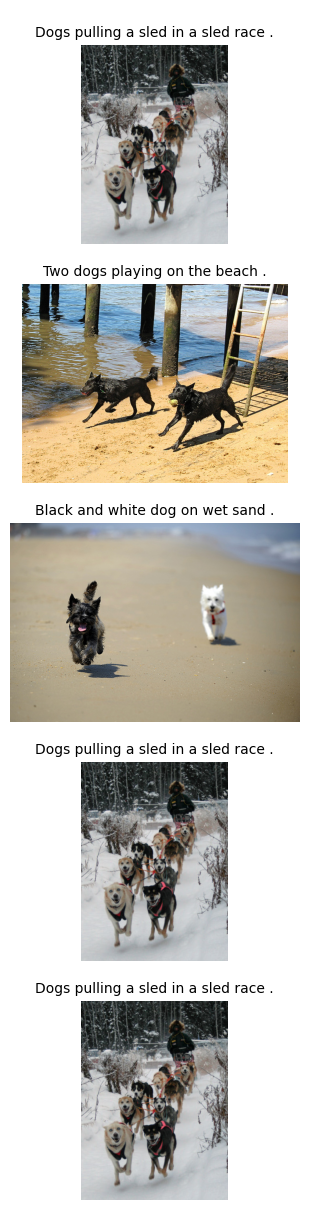

In [47]:
visual_dataset = full[full['avg_score'] > 0.5].sample(5).copy()

visual_dataset.reset_index(inplace=True)

images = []
labels = []

for i in range(visual_dataset.shape[0]):
    images.append(f'{PATH_TRAIN_IMAGE_FOLDER}/{visual_dataset.iloc[i]["image_x"]}')
    labels.append(visual_dataset.iloc[i]['query_text'])

image_show(images, labels)

**Вывод**

Данные объеденены и готовы к предобработке. Информация о мнении экспертов и краудсорсинга объединена, а также способом регрессии были восстановлены потенциальные оценки экспертов. Подготовлена фукнция для просмотра изображений

# Подготовка данных

## Юридическое ограничение

В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.
В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

⎢ This image is unavailable in your country in compliance with local laws.

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому необходимо очистить данные от проблемного контента. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер. 

In [48]:
stop_words = [
    'baby',
    'child',
    'little boy',
    'little girl',
    'kid',
    'kids',
    'young girl',
    'young boy',
    'boy',
    'girl',
    'children'
]

In [49]:
def stop_word_c(txt):
    txt = txt.lower()
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(txt)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_tokens])

    for word in stop_words:
        word_len = len(word.split())

        if word_len > 1:
            if word in txt:
                return True
        elif word_len == 1:
            if word in txt.split():
                return True

    return False

In [50]:
full['stopw'] = full['query_text'].apply(stop_word_c)

full[full['stopw'] == True].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7439 entries, 3 to 36398
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_x     7439 non-null   object 
 1   query_id    7439 non-null   object 
 2   avg_score   6109 non-null   float64
 3   query_text  7439 non-null   object 
 4   stopw       7439 non-null   bool   
dtypes: bool(1), float64(1), object(3)
memory usage: 297.9+ KB


Определим список фотографий где изображены дети, чтобы не допустить эту информацию в датасет для обучения

In [51]:
bad_index = full[full['stopw'] == True].reset_index()

In [52]:
bad_index

index                    image_x                    query_id  avg_score  \
0         3  1056338697_4f7d7ce270.jpg  114051287_dd85625a04.jpg#2   0.045580   
1         4  1056338697_4f7d7ce270.jpg  114051287_dd85625a04.jpg#2   0.045580   
2         5  1056338697_4f7d7ce270.jpg  114051287_dd85625a04.jpg#2   0.045580   
3         6  1056338697_4f7d7ce270.jpg  114051287_dd85625a04.jpg#2   0.045580   
4         7  1056338697_4f7d7ce270.jpg  114051287_dd85625a04.jpg#2   0.045580   
...     ...                        ...                         ...        ...   
7434  36394   496110746_a93ca191ae.jpg  537532165_e4b7c0e61a.jpg#2   0.380293   
7435  36395   496110746_a93ca191ae.jpg  537532165_e4b7c0e61a.jpg#2   0.380293   
7436  36396   624742559_ff467d8ebc.jpg  537532165_e4b7c0e61a.jpg#2   0.270646   
7437  36397   624742559_ff467d8ebc.jpg  537532165_e4b7c0e61a.jpg#2   0.270646   
7438  36398   624742559_ff467d8ebc.jpg  537532165_e4b7c0e61a.jpg#2   0.270646   

                                             query_text  stopw  
0             A boy in glasses is wearing a red shirt .   True  
1             A boy in glasses is wearing a red shirt .   True  
2             A boy in glasses is wearing a red shirt .   True  
3             A boy in glasses is wearing a red shirt .   True  
4             A boy in glasses is wearing a red shirt .   True  
...                                                 ...    ...  
7434  A kid hangs upside down on the monkey bars at ...   True  
7435  A kid hangs upside down on the monkey bars at ...   True  
7436  A kid hangs upside down on the monkey bars at ...   True  
7437  A kid hangs upside down on the monkey bars at ...   True  
7438  A kid hangs upside down on the monkey bars at ...   True  

[7439 rows x 6 columns]

In [53]:
bad_index = [i[:-2] for i in bad_index['query_id']]

In [54]:
bad_indexs = []
for i in bad_index:
    if i not in bad_indexs:
        bad_indexs.append(i)

In [55]:
bad_indexs

['114051287_dd85625a04.jpg',
 '1427391496_ea512cbe7f.jpg',
 '2436081047_bca044c1d3.jpg',
 '2490768374_45d94fc658.jpg',
 '2549968784_39bfbe44f9.jpg',
 '2588927489_f4da2f11ec.jpg',
 '2594042571_2e4666507e.jpg',
 '2718495608_d8533e3ac5.jpg',
 '3192069971_83c5a90b4c.jpg',
 '3485425825_c2f3446e73.jpg',
 '3545652636_0746537307.jpg',
 '496110746_a93ca191ae.jpg',
 '700884207_d3ec546494.jpg',
 '1096395242_fc69f0ae5a.jpg',
 '1287475186_2dee85f1a5.jpg',
 '1714316707_8bbaa2a2ba.jpg',
 '197504190_fd1fc3d4b7.jpg',
 '2041867793_552819a40b.jpg',
 '2140182410_8e2a06fbda.jpg',
 '2251747182_6b67a3ab8b.jpg',
 '2271755053_e1b1ec8442.jpg',
 '2274992140_bb9e868bb8.jpg',
 '2333288869_8c01e4c859.jpg',
 '2370481277_a3085614c9.jpg',
 '2396691909_6b8c2f7c44.jpg',
 '2415803492_56a673dc25.jpg',
 '2443380641_7b38d18f5b.jpg',
 '2479652566_8f9fac8af5.jpg',
 '2480327661_fb69829f57.jpg',
 '2510020918_b2ca0fb2aa.jpg',
 '2521770311_3086ca90de.jpg',
 '2667015110_1670324a33.jpg',
 '2675685200_0913d84d9b.jpg',
 '2731171552_4

In [56]:
full

image_x                     query_id  avg_score  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   0.463502   
1      2182488373_df73c7cc09.jpg  1056338697_4f7d7ce270.jpg#2   0.045580   
2      2647049174_0fb47cee2e.jpg  1056338697_4f7d7ce270.jpg#2        NaN   
3      1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   0.045580   
4      1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   0.045580   
...                          ...                          ...        ...   
36499  3123351642_3794f2f601.jpg  3108732084_565b423162.jpg#2   0.463502   
36500  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   
36501  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   
36502  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   
36503  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   

                                              query_text  stopw  
0      A woman is signaling is to traffic , as seen f...  False  
1      A woman is signaling is to traffic , as seen f...  False  
2      A woman is signaling is to traffic , as seen f...  False  
3              A boy in glasses is wearing a red shirt .   True  
4              A boy in glasses is wearing a red shirt .   True  
...                                                  ...    ...  
36499                                      a snowboarder  False  
36500                                      a snowboarder  False  
36501                                      a snowboarder  False  
36502                                      a snowboarder  False  
36503                                      a snowboarder  False  

[36504 rows x 5 columns]

In [57]:
full = full.loc[full['stopw'] == False]

In [59]:
full = full.dropna()

In [61]:
full

image_x                     query_id  avg_score  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   0.463502   
1      2182488373_df73c7cc09.jpg  1056338697_4f7d7ce270.jpg#2   0.045580   
77     1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.045580   
78     1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.045580   
79     1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.045580   
...                          ...                          ...        ...   
36499  3123351642_3794f2f601.jpg  3108732084_565b423162.jpg#2   0.463502   
36500  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   
36501  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   
36502  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   
36503  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   

                                              query_text  stopw  
0      A woman is signaling is to traffic , as seen f...  False  
1      A woman is signaling is to traffic , as seen f...  False  
77     A woman wearing black clothes , a purple scarf...  False  
78     A woman wearing black clothes , a purple scarf...  False  
79     A woman wearing black clothes , a purple scarf...  False  
...                                                  ...    ...  
36499                                      a snowboarder  False  
36500                                      a snowboarder  False  
36501                                      a snowboarder  False  
36502                                      a snowboarder  False  
36503                                      a snowboarder  False  

[24667 rows x 5 columns]

## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [62]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.to(DEVICE)
model.eval()

preprocess = weights.transforms(antialias=True)

return_nodes = {'flatten': 'flatten'}
feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)

image_vectors = {}

In [63]:
def get_image_vector(image_path):

    image = read_image(image_path).unsqueeze(0)
    model_input = preprocess(image).to(DEVICE)

    with torch.no_grad():

        features = feature_extractor(model_input)
        flatten_fts = features["flatten"].squeeze()

        return flatten_fts.to('cpu').detach().numpy()

In [64]:
get_image_vector(PATH_TRAIN_IMAGE_FOLDER + '/115684808_cb01227802.jpg').shape

(512,)

In [65]:
def images2vector(folder):
    count = 0

    for p in Path(folder).glob('*.jpg'):
        if p.name not in bad_indexs:
            count+=1

    with tqdm(total=count) as pbar:
        for p in Path(folder).glob('*.jpg'):
            if p.name not in bad_indexs:
                image_vectors[p.name] = get_image_vector(folder + f'/{p.name}')

                pbar.update(1)

In [66]:
images2vector(PATH_TRAIN_IMAGE_FOLDER)

  0%|          | 0/751 [00:00<?, ?it/s]

In [67]:
img1 = list(image_vectors.keys())[0]
image_vectors[img1].shape

(512,)

In [68]:
print(f'''Векторизация изображения на основе модели resnet18 позволило получить вектор длинной {image_vectors[img1].shape[0]}
Уменьшение вектора позволит сэкономить ресурсы и вычислительное время при обучении.''')

Векторизация изображения на основе модели resnet18 позволило получить вектор длинной 512
Уменьшение вектора позволит сэкономить ресурсы и вычислительное время при обучении.


## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.

In [69]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModel.from_pretrained('distilbert-base-uncased')

model.to(DEVICE)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [70]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [71]:
def text2vector(sentences):
    encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=128, return_tensors='pt').to(DEVICE)

    with torch.no_grad():
        model_output = model(**encoded_input)

    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    pbar.update(1)
    ar = sentence_embeddings[0].to('cpu').detach().numpy()
    return ar

In [72]:
with tqdm(total=full.shape[0]) as pbar:
        full['text2vec'] = full['query_text'].apply(lambda x: text2vector(x))

  0%|          | 0/24667 [00:00<?, ?it/s]

C:\Users\SerKer\AppData\Local\Temp\ipykernel_11068\3048852078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full['text2vec'] = full['query_text'].apply(lambda x: text2vector(x))


In [73]:
print(f'После векторизации текста был создан Tensor размером {full.iloc[0]["text2vec"].shape}')

После векторизации текста был создан Tensor размером (768,)


## Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [75]:
full.reset_index(inplace=True)
full = full.drop('index', axis=1)

In [76]:
full

image_x                     query_id  avg_score  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   0.463502   
1      2182488373_df73c7cc09.jpg  1056338697_4f7d7ce270.jpg#2   0.045580   
2      1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.045580   
3      1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.045580   
4      1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.045580   
...                          ...                          ...        ...   
24662  3123351642_3794f2f601.jpg  3108732084_565b423162.jpg#2   0.463502   
24663  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   
24664  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   
24665  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   
24666  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   

                                              query_text  stopw  \
0      A woman is signaling is to traffic , as seen f...  False   
1      A woman is signaling is to traffic , as seen f...  False   
2      A woman wearing black clothes , a purple scarf...  False   
3      A woman wearing black clothes , a purple scarf...  False   
4      A woman wearing black clothes , a purple scarf...  False   
...                                                  ...    ...   
24662                                      a snowboarder  False   
24663                                      a snowboarder  False   
24664                                      a snowboarder  False   
24665                                      a snowboarder  False   
24666                                      a snowboarder  False   

                                                text2vec  
0      [-0.041528873, -0.021738831, 0.12582226, -0.18...  
1      [-0.041528873, -0.021738831, 0.12582226, -0.18...  
2      [0.13004301, -0.31328273, -0.11671894, 0.08345...  
3      [0.13004301, -0.31328273, -0.11671894, 0.08345...  
4      [0.13004301, -0.31328273, -0.11671894, 0.08345...  
...                                                  ...  
24662  [0.11044545, 0.05272508, 0.07096708, -0.015142...  
24663  [0.11044545, 0.05272508, 0.07096708, -0.015142...  
24664  [0.11044545, 0.05272508, 0.07096708, -0.015142...  
24665  [0.11044545, 0.05272508, 0.07096708, -0.015142...  
24666  [0.11044545, 0.05272508, 0.07096708, -0.015142...  

[24667 rows x 6 columns]

In [77]:
drop_index = []
for i in range(len(full)):
    photo = full['image_x'][i]
    if photo in bad_indexs:
        drop_index.append(full.index[i])

In [78]:
full

image_x                     query_id  avg_score  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   0.463502   
1      2182488373_df73c7cc09.jpg  1056338697_4f7d7ce270.jpg#2   0.045580   
2      1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.045580   
3      1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.045580   
4      1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.045580   
...                          ...                          ...        ...   
24662  3123351642_3794f2f601.jpg  3108732084_565b423162.jpg#2   0.463502   
24663  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   
24664  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   
24665  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   
24666  3354330935_de75be9d2f.jpg  3108732084_565b423162.jpg#2   0.270646   

                                              query_text  stopw  \
0      A woman is signaling is to traffic , as seen f...  False   
1      A woman is signaling is to traffic , as seen f...  False   
2      A woman wearing black clothes , a purple scarf...  False   
3      A woman wearing black clothes , a purple scarf...  False   
4      A woman wearing black clothes , a purple scarf...  False   
...                                                  ...    ...   
24662                                      a snowboarder  False   
24663                                      a snowboarder  False   
24664                                      a snowboarder  False   
24665                                      a snowboarder  False   
24666                                      a snowboarder  False   

                                                text2vec  
0      [-0.041528873, -0.021738831, 0.12582226, -0.18...  
1      [-0.041528873, -0.021738831, 0.12582226, -0.18...  
2      [0.13004301, -0.31328273, -0.11671894, 0.08345...  
3      [0.13004301, -0.31328273, -0.11671894, 0.08345...  
4      [0.13004301, -0.31328273, -0.11671894, 0.08345...  
...                                                  ...  
24662  [0.11044545, 0.05272508, 0.07096708, -0.015142...  
24663  [0.11044545, 0.05272508, 0.07096708, -0.015142...  
24664  [0.11044545, 0.05272508, 0.07096708, -0.015142...  
24665  [0.11044545, 0.05272508, 0.07096708, -0.015142...  
24666  [0.11044545, 0.05272508, 0.07096708, -0.015142...  

[24667 rows x 6 columns]

In [79]:
full = full.drop(index=drop_index).reset_index()

In [80]:
def image2vector(row):
    img = row['image_x']
    return image_vectors[img]

In [81]:
full['image2vec'] = full.apply(image2vector, axis=1)

In [82]:
def join_vectors(row):
    return np.concatenate((row['text2vec'], row['image2vec']))

In [83]:
full['vec'] = full.apply(join_vectors, axis=1)

In [84]:
df = full.copy()

In [85]:
df.head()

index                    image_x                     query_id  avg_score  \
0      0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   0.463502   
1      1  2182488373_df73c7cc09.jpg  1056338697_4f7d7ce270.jpg#2   0.045580   
2      2  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.045580   
3      3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.045580   
4      4  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.045580   

                                          query_text  stopw  \
0  A woman is signaling is to traffic , as seen f...  False   
1  A woman is signaling is to traffic , as seen f...  False   
2  A woman wearing black clothes , a purple scarf...  False   
3  A woman wearing black clothes , a purple scarf...  False   
4  A woman wearing black clothes , a purple scarf...  False   

                                            text2vec  \
0  [-0.041528873, -0.021738831, 0.12582226, -0.18...   
1  [-0.041528873, -0.021738831, 0.12582226, -0.18...   
2  [0.13004301, -0.31328273, -0.11671894, 0.08345...   
3  [0.13004301, -0.31328273, -0.11671894, 0.08345...   
4  [0.13004301, -0.31328273, -0.11671894, 0.08345...   

                                           image2vec  \
0  [0.6641444, 3.0099196, 2.8951252, 0.94437975, ...   
1  [0.0752182, 4.1649494, 0.788956, 0.7554564, 0....   
2  [0.6641444, 3.0099196, 2.8951252, 0.94437975, ...   
3  [0.6641444, 3.0099196, 2.8951252, 0.94437975, ...   
4  [0.6641444, 3.0099196, 2.8951252, 0.94437975, ...   

                                                 vec  
0  [-0.041528873, -0.021738831, 0.12582226, -0.18...  
1  [-0.041528873, -0.021738831, 0.12582226, -0.18...  
2  [0.13004301, -0.31328273, -0.11671894, 0.08345...  
3  [0.13004301, -0.31328273, -0.11671894, 0.08345...  
4  [0.13004301, -0.31328273, -0.11671894, 0.08345...

In [86]:
print(f'Длина итогового вектора равна {df.iloc[0]["text2vec"].shape[0]} + {df.iloc[0]["image2vec"].shape[0]} = {len(df.iloc[0]["vec"])}')

Длина итогового вектора равна 768 + 512 = 1280


In [87]:
print(f'Вывод: после объединения двух векторов мы получаем третьи вектор длиной {len(df.iloc[0]["vec"])}, который содержит конкатинированные признаки для дальнейшего обучения.')

Вывод: после объединения двух векторов мы получаем третьи вектор длиной 1280, который содержит конкатинированные признаки для дальнейшего обучения.


## Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 8:2 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

### Разделение на train и test

In [88]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=RANDOM_STATE)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['avg_score']), y=df['avg_score'], groups=df['image_x']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

In [89]:
features_train = torch.FloatTensor(list(train_df.loc[:, 'vec'].values))
features_test = torch.FloatTensor(list(test_df.loc[:, 'vec'].values))

C:\Users\SerKer\AppData\Local\Temp\ipykernel_11068\3748162826.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  features_train = torch.FloatTensor(list(train_df.loc[:, 'vec'].values))


In [90]:
target_train = torch.FloatTensor(train_df['avg_score'].values).reshape(-1, 1)
target_test = torch.FloatTensor(test_df['avg_score'].values).reshape(-1, 1)

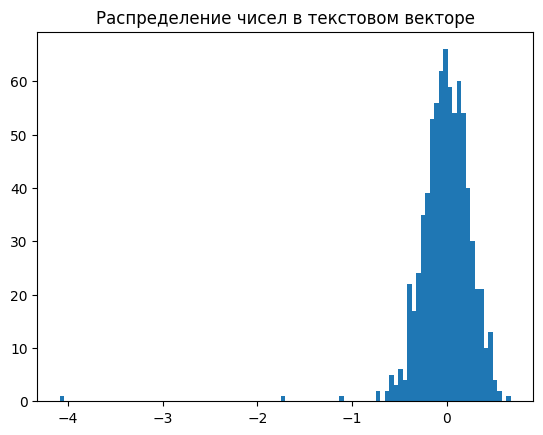

In [91]:
plt.hist(df.iloc[0]['text2vec'], bins=100)

plt.title('Распределение чисел в текстовом векторе')
plt.show()

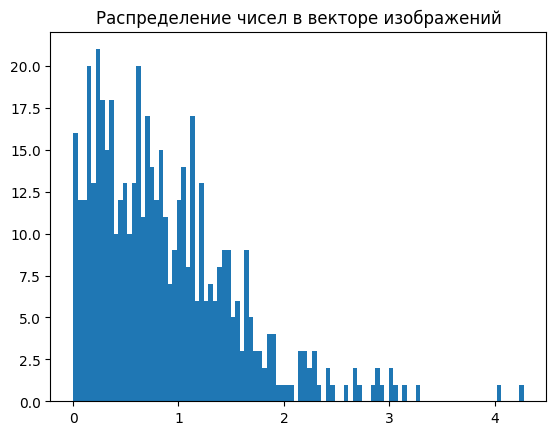

In [92]:
plt.hist(df.iloc[0]['image2vec'], bins=100)

plt.title('Распределение чисел в векторе изображений')
plt.show()

Текст и изображения распределены по разному, сделаем ниже преобразование - масштабирование

In [93]:
class TorchStandardScaler:
    def fit(self, x):
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
    def transform(self, x):
        x -= self.mean
        x /= (self.std + 1e-7)
        return x

In [94]:
# процесс масштабирования
scaler = TorchStandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

## LinearRegression

Обучим модель линейной регрессии и воспользуемся метрикой среднеквадратической ошибки RMSE. Чем ближе значение к нулю, тем лучше качество. Преимущество выбора данной метрики в том, что она измеряется в той же единице, что и целевая переменная.

In [96]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

LinearRegression()

In [97]:
pred = model_lr.predict(features_test)
rmse_lr = mean_squared_error(target_test, pred) ** 0.5

print(f'RMSE для LinearRegression равно', round(rmse_lr, 3))

RMSE для LinearRegression равно 71.685


## NerualNetwork

Напишем полносвязную нейронную сеть используя оптимизатор Adam и комбинацию функций активации ReLU и Sigmoid

In [98]:
class CustomDataset(Dataset):
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

In [99]:
# создадим DataLoader
train_dataset = CustomDataset(features_train, target_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDataset(features_test, target_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [100]:
# проверим работу
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 1280])
Labels batch shape: torch.Size([32, 1])


In [101]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1280, 10240)
        self.fc2 = nn.Linear(10240, 4096)
        self.fc3 = nn.Linear(4096, 2048)
        self.fc4 = nn.Linear(2048, 512)
        self.fc5 = nn.Linear(512, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 1)

        self.dp = nn.Dropout(p=0.5)
        self.relu = nn.LeakyReLU()
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dp(x)

        x = self.fc3(x)
        x = self.sig(x)

        x = self.fc4(x)
        x = self.relu(x)

        x = self.fc5(x)
        x = self.relu(x)
        x = self.dp(x)

        x = self.fc6(x)
        x = self.sig(x)

        x = self.fc7(x)
        x = self.relu(x)

        return x

In [102]:
models = Net()
models.to(DEVICE)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(models.parameters(), lr=5e-6)

epochs = 10
min_valid_loss = np.inf

In [103]:
for e in range(epochs):
    train_loss = 0.0
    models.train()
    for data, labels in train_dataloader:
        data, labels = data.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        target = models(data)
        loss = torch.sqrt(criterion(target,labels))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    valid_loss = 0.0
    models.eval()

    for data, labels in test_dataloader:
        data, labels = data.to(DEVICE), labels.to(DEVICE)

        target = models(data)
        loss = torch.sqrt(criterion(target, labels))
        valid_loss += loss.item() * data.size(0)

    print(f'Эпоха {e+1} \t\t Training Loss: {train_loss / len(train_dataloader)} \t\t Validation Loss: {valid_loss / len(test_dataloader)}')
    if min_valid_loss > valid_loss:
        print(f'({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Сохранение модели')
        min_valid_loss = valid_loss
        torch.save(models.state_dict(), TEMP + '/saved_model.pth')

Эпоха 1 		 Training Loss: 7.048875981008813 		 Validation Loss: 5.960444159747567
(inf--->762.936852) 	 Сохранение модели
Эпоха 2 		 Training Loss: 5.515132309676941 		 Validation Loss: 6.472809352912009
Эпоха 3 		 Training Loss: 4.2601577235389145 		 Validation Loss: 7.021541856811382
Эпоха 4 		 Training Loss: 3.213360978293807 		 Validation Loss: 7.767569560208358
Эпоха 5 		 Training Loss: 2.535130052896348 		 Validation Loss: 7.510691530420445
Эпоха 6 		 Training Loss: 2.170119002906043 		 Validation Loss: 7.394281917368062
Эпоха 7 		 Training Loss: 1.9261112932594084 		 Validation Loss: 7.348796717938967
Эпоха 8 		 Training Loss: 1.7510857722481163 		 Validation Loss: 7.3656281302683055
Эпоха 9 		 Training Loss: 1.6195945734222155 		 Validation Loss: 7.384850999573246
Эпоха 10 		 Training Loss: 1.5028247286786223 		 Validation Loss: 7.252212009625509


# Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [104]:
# загрузим модель
models = Net()
models.to(DEVICE)

models.load_state_dict(torch.load(TEMP + '/saved_model.pth'))
models.eval()

Net(
  (fc1): Linear(in_features=1280, out_features=10240, bias=True)
  (fc2): Linear(in_features=10240, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=2048, bias=True)
  (fc4): Linear(in_features=2048, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=64, bias=True)
  (fc7): Linear(in_features=64, out_features=1, bias=True)
  (dp): Dropout(p=0.5, inplace=False)
  (relu): LeakyReLU(negative_slope=0.01)
  (sig): Sigmoid()
)

In [105]:
test_images_csv = pd.read_csv(PATH_TEST_IMAGES)
test_images_csv.info()
test_images_csv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

In [106]:
test_queries_csv = pd.read_csv(PATH_TEST_QUERIES, sep='|', index_col=0)
test_queries_csv.info()
test_queries_csv.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


query_id  \
215  3044745642_1d0784ff29.jpg#0   
159   269650644_059a84ece5.jpg#4   
65   2121140070_a09644550b.jpg#0   
97   2399551242_c62a46dd5f.jpg#2   
100  2428094795_d3a8f46046.jpg#0   

                                            query_text  \
215  At the bottom of a set of stairs , there are t...   
159         People using an outdoor ice skating rink .   
65   A group of people are playing with a large red...   
97   Kids in bathing suits with water splashing aro...   
100        A child in a fuzzy blue hat on a tricycle .   

                         image  
215  3044745642_1d0784ff29.jpg  
159   269650644_059a84ece5.jpg  
65   2121140070_a09644550b.jpg  
97   2399551242_c62a46dd5f.jpg  
100  2428094795_d3a8f46046.jpg

In [107]:
image_vectors = {}

# воспользуемся ранее созданным методом
images2vector(PATH_TEST_IMAGE_FOLDER)

  0%|          | 0/100 [00:00<?, ?it/s]

In [108]:
urllib.request.urlretrieve('https://upload.wikimedia.org/wikipedia/commons/f/f9/No-image-available.jpg', './cache/No-image-available.jpg')

('./cache/No-image-available.jpg', <http.client.HTTPMessage at 0x280d0a014f0>)

In [109]:
def search(txt):
    if stop_word_c(txt):
        return './cache/No-image-available.jpg', f'{txt}\nThis image is unavailable in your country in compliance with local laws', None

    vec = text2vector(txt)

    data = []
    images = []

    for key in image_vectors.keys():
        images.append(key)

        img = image_vectors[key]
        data.append(np.concatenate((vec, img)))

    with torch.no_grad():
        pred = models(scaler.transform(torch.FloatTensor(data)).to(DEVICE)).to('cpu')
        idx = pred.numpy().argmax(axis=0)[0]

    return f'{PATH_TEST_IMAGE_FOLDER}/{images[idx]}', txt, pred[idx].numpy()[0]

In [110]:
queries = list(test_queries_csv.sample(10)['query_text'])

In [111]:
images = []
labels = []
scores = []

for i in range(len(queries)):

    image_path, title, score = search(queries[i])

    images.append(image_path)
    if score == None:
        scores.append(None)
    else:
        scores.append(round(score, 2))
    labels.append(title)

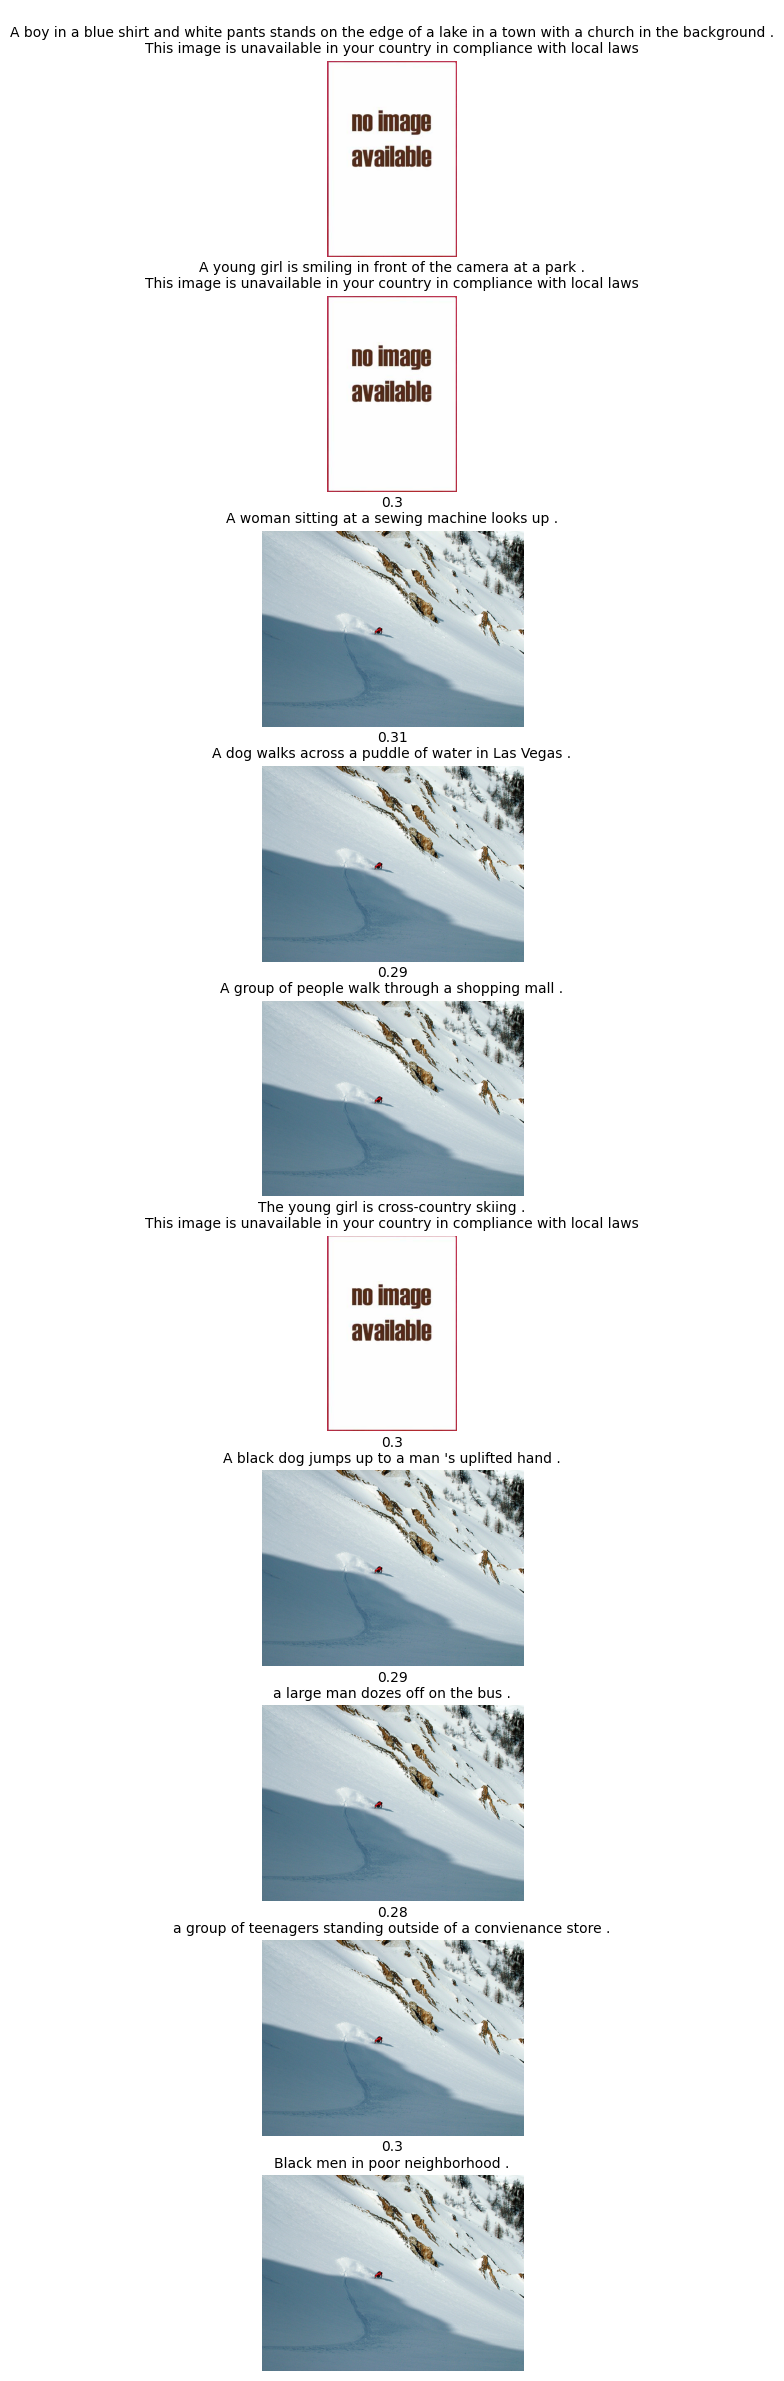

In [112]:
image_show(images, labels, scores)

# Выводы


Данные о фотографиях и их описании загружены! Можно отметить тот факт, что все фотографии в тренировачных датасетах имеют отношение к второй группе в базе данных, которая обозначается (#2), тогда как в тестовом наборе данные есть вариация этих групп, потенциально это может сыграть на качестве прогноза обученной модели.

**Описание данных**

**train_dataset**

* `image` - изображение в формате `jpg`
* `query_id` - идентификатор описания
* `query_text` - описание

**CrowdAnnotations**

* `image` - Имя файла изображения;
* `query_id` - Идентификатор описания;
* `positive` - Доля людей, подтвердивших, что описание соответствует изображению;
* `ex_1` - Количество человек, подтвердивших, что описание соответствует изображению;
* `ex_2` - Количество человек, подтвердивших, что описание не соответствует изображению.

**ExpertAnnotations**

Описание колонок:
* `image` - Имя файла изображения;
* `query_id` - Идентификатор описания;
* `ex_1` — оценка 1 эксперта;
* `ex_2` — оценка 2 эксперта;
* `ex_3` — оценка 3 эксперта.


При объединении оценок была обучена модель для восстановления оценок экспертов на основе данных где есть оценка краудсорсинга и экспертов. В качестве модели была модель CatBoost


Наилучшее качество показывает модель на основе полносвзанной нейронной сети. 